## Case Study on Gold Prices using Time series analysis

In [ ]:
!pip install chart_studio

In [ ]:
pip install pmdarima

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pmdarima.arima import auto_arima

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



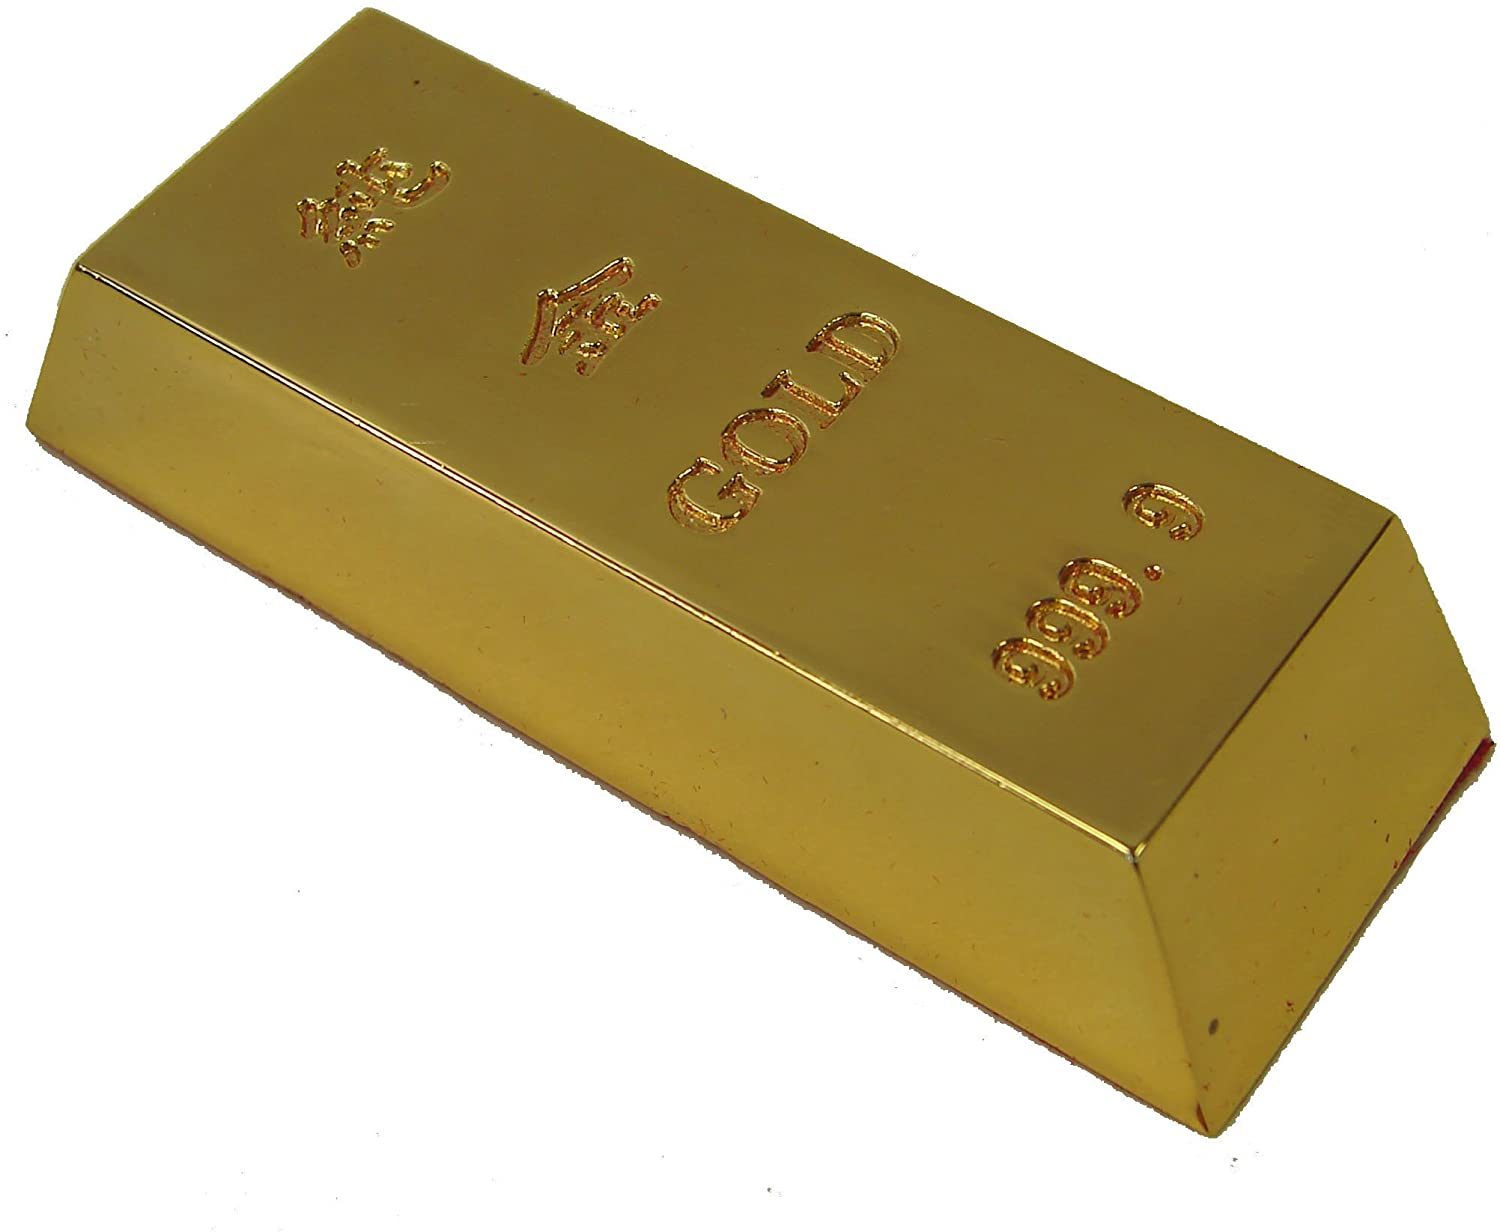

Gold Bar

In [ ]:
gold = pd.read_csv('/content/drive/MyDrive/Excel Sheets/monthly_csv.csv',index_col='Date', parse_dates=['Date'])

In [ ]:
gold = gold.fillna(method='ffill')

The ffill method fills Empty or NA data with the data present in the row above it.

# Gold and it's price in dollars


We had taken a dataset that has all the prices of gold in USA (in $ per ounce) for
each month from the year 1950 to the July of 2020 in the middle of the COVID-19 pandemic.

In [ ]:
gold

,Price
Date,
1950-01-01,34.730
1950-02-01,34.730
1950-03-01,34.730
1950-04-01,34.730
1950-05-01,34.730
...,...
2020-03-01,1593.764
2020-04-01,1680.030
2020-05-01,1715.697


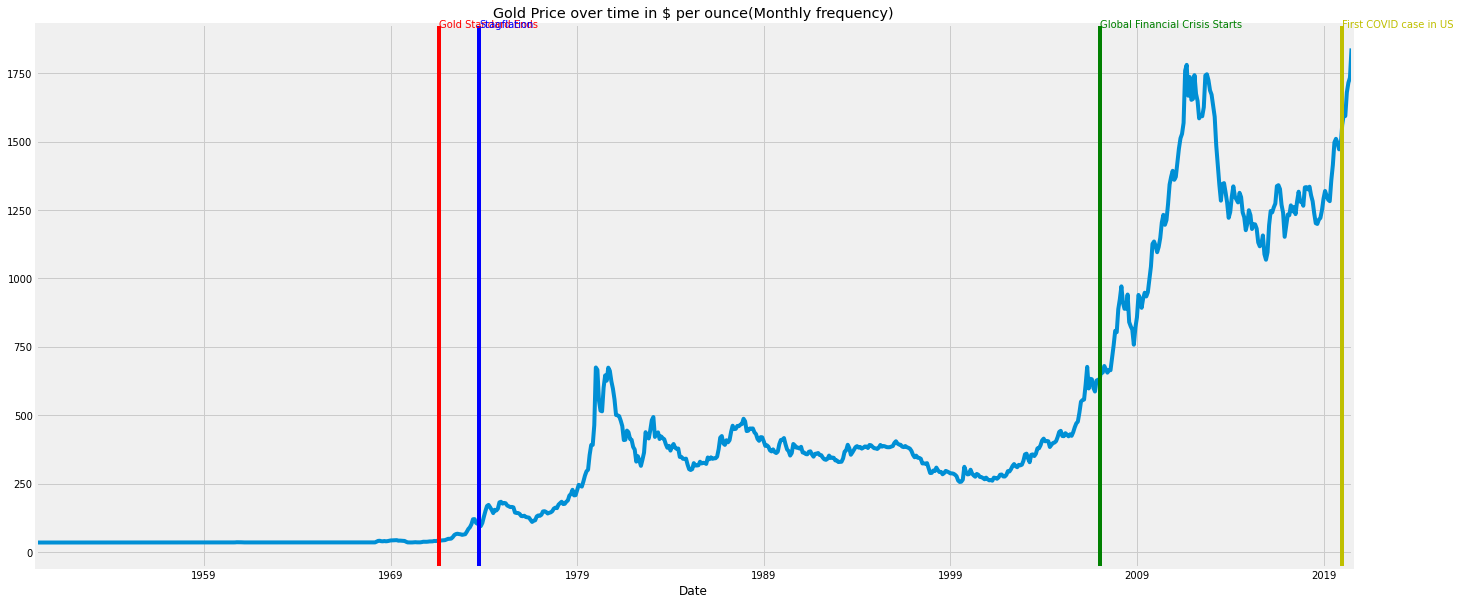

In [ ]:
rcParams['figure.figsize'] = 21, 10
gold["Price"].plot() 
plt.title('Gold Price over time in $ per ounce(Monthly frequency)')

label_list = [
    (pd.to_datetime("1971-08-15"), 'Gold Standard Ends', 'r'),
    (pd.to_datetime("2007-01-01"), 'Global Financial Crisis Starts', 'g'),
    (pd.to_datetime("2020-01-20"), 'First COVID case in US', 'y'),
    (pd.to_datetime("1973-10-25"), 'Stagflation', 'b')
]

ax = plt.gca()

for date_point, label, clr in label_list:
    plt.axvline(x=date_point, color=clr)
    plt.text(date_point, ax.get_ylim()[1]-4, label,
             horizontalalignment='left',
             verticalalignment='center',
             color=clr)

plt.show()

# A very short history of Gold prices

We have graphed the whole data in a line plot and it is easy to see that the price of gold has increased very much from half a century ago.
But it is also hard to miss the fact that from 1950 to somewhere in 1970's the price of gold has remained very stable.
This is because of the fact that there was a fixed exchange rate b/w gold and dollars (it was fixed at 35$/ounce), and all other countries in the world with a free market economy agreed to have fixed exchange rate with the dollar at the Bretton Woods international monetary agreement of 1944.
This was abandoned in US by then president Nixon in August of 1971 because of economic pressures of some economists, the war with Ho Chi Minh's Vietnam, and the debt that was incurred by the Federal Government. Thus dollar became a 'fiat' currency. These kind of fiat currencies give central banks a greater control over the econmoy.

---
After the gold standard was dropped the price of gold was controlled by the invisible hand of the free market. Gold as an asset was popular, whenever there is uncertainity in the market. Gold is also used as a very good asset to invest if you suspect high inflation coming. It is usually seen as a safe bet to invest in times of uncertainity. That's why you can see gold prices peak at some times such as in 1980, when there was very high inflation and low growth called 'Stagflation'. People overwelmingly invested in Gold fearing a high inflation, but the incoming Republican Reagan Administration made sure that inflation was low, thus incurring a recession and the price of gold crashed.
There was also a gold price bubble in 2011 which burst. And the COVID pandemic of 2020 has also made the price of gold rise very significantly after the markets were thrown into uncertainity after the lockdown imposed in the country.
The price of Gold is suspected to go down after the pandemic is gone and thus it is now a price bubble waiting to burst.


# Decomposition and Stationarity

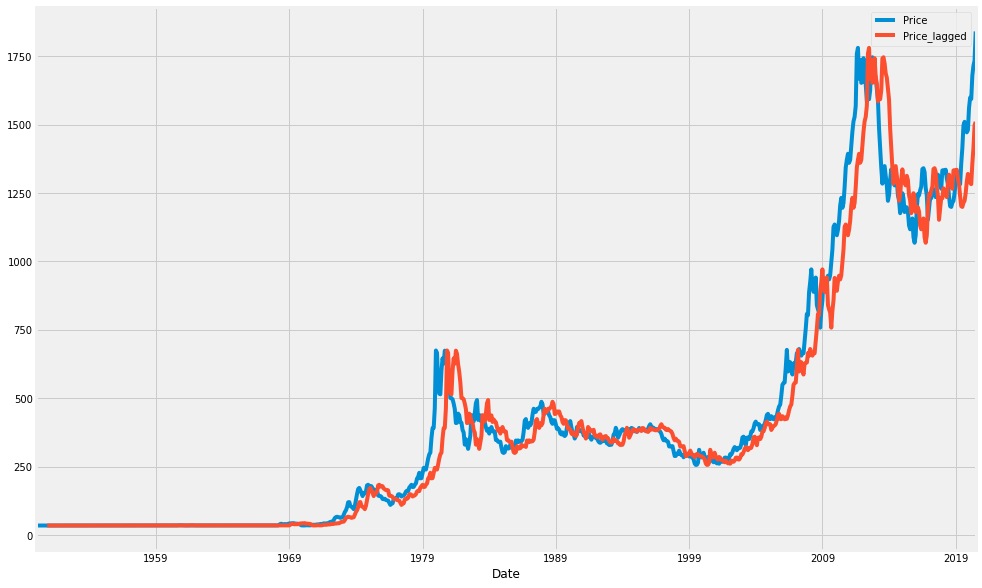

In [ ]:
gold["Price"].plot(legend=True,figsize=(15,10))
shifted = gold["Price"].shift(10).plot(legend=True)
shifted.legend(['Price','Price_lagged'])
plt.show()

The gold graph shifted by 10 months

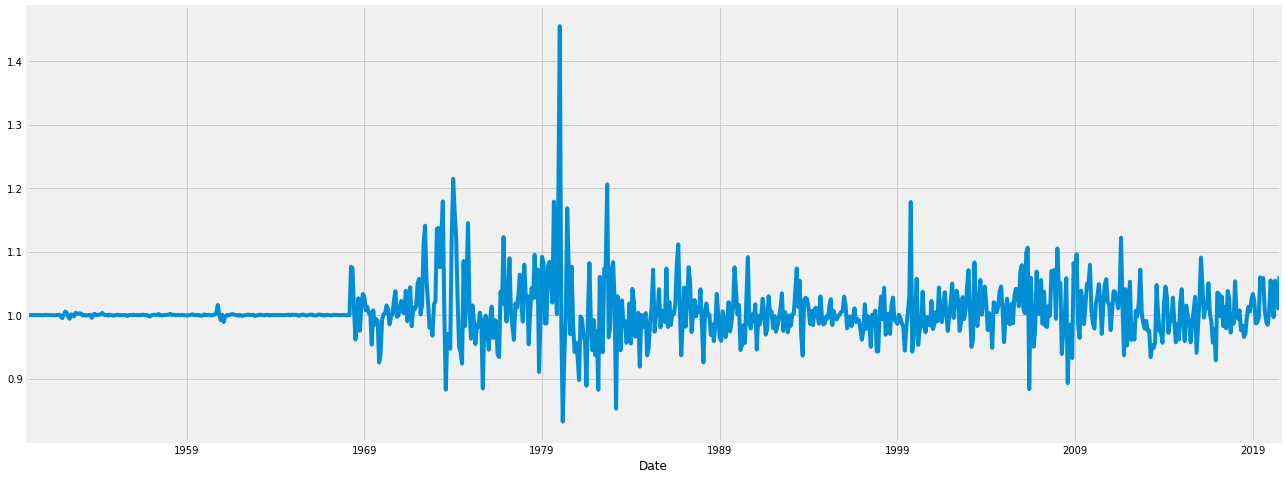

In [ ]:
X = gold.Price.div(gold.Price.shift())
X.plot(figsize=(20,8))

The graph of the amount of change from one month to another.

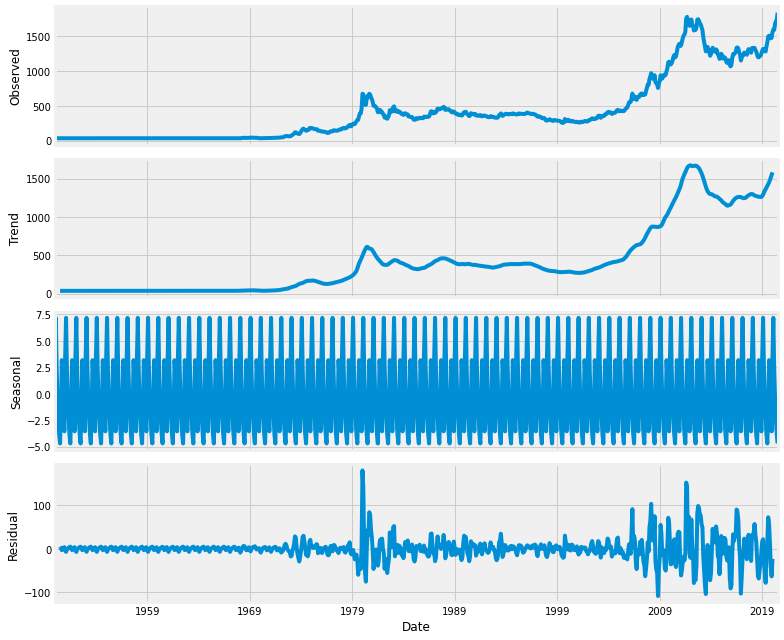

In [ ]:
rcParams['figure.figsize'] = 11, 9
decomposed_gold_volume = sm.tsa.seasonal_decompose(gold["Price"], model ='additive')
figure = decomposed_gold_volume.plot()
plt.show()

These are the components of a time series
*   **Trend** - Consistent upwards or downwards slope of a time series
*   **Seasonality** - Clear periodic pattern of a time series(like sine funtion)
*   **Noise**  - Outliers or missing values

A time series can be written as Observed = Trend + Seasonality + Noise

Or as multiplicative Observed = Trend x Seasonality x noise

Here we used the additive model.

A time series must be stationary so that we can use ARIMA and other models.

A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations 

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

**Null Hypothesis**: The series has a unit root (value of a =1)

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

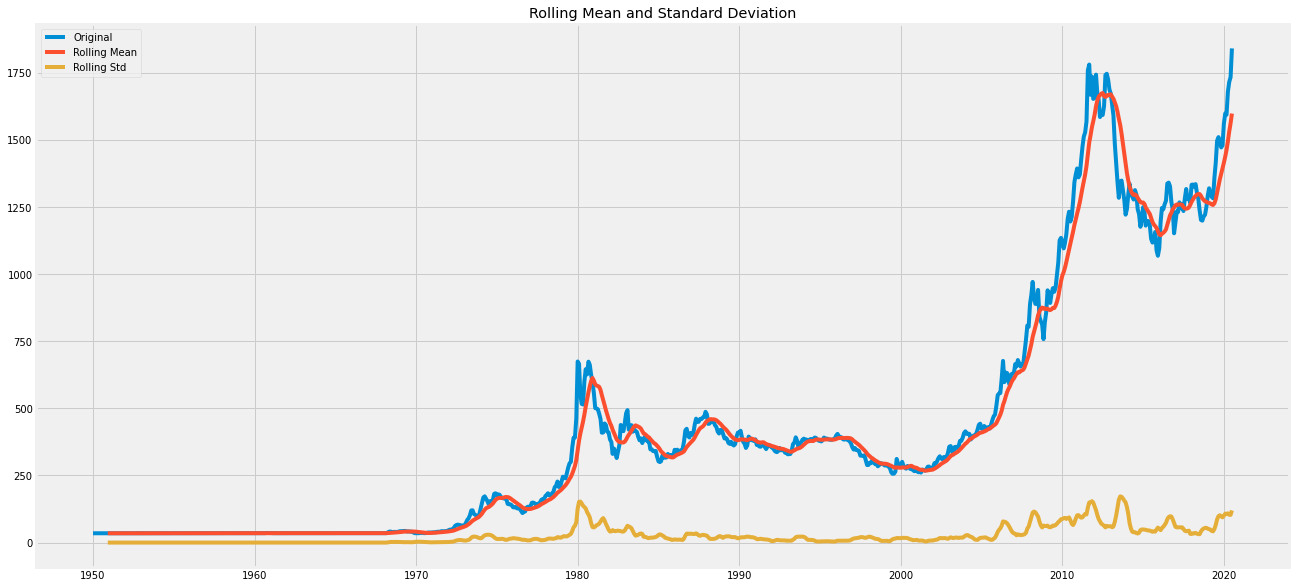

Results of dickey fuller test
Test Statistics                  0.814324
p-value                          0.991864
No. of lags used                11.000000
Number of observations used    835.000000
critical value (1%)             -3.438206
critical value (5%)             -2.865008
critical value (10%)            -2.568616
dtype: float64


In [ ]:

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries,label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Price'],autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(gold)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than **0.05** so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

One way to eliminate the non-stationarity in the time series is just differencing.
Differencing is taking the differece with a particular time lag.

In the following code we difference the dataset and put it in the Dickey Fuller test to find how stationary the time series is now.

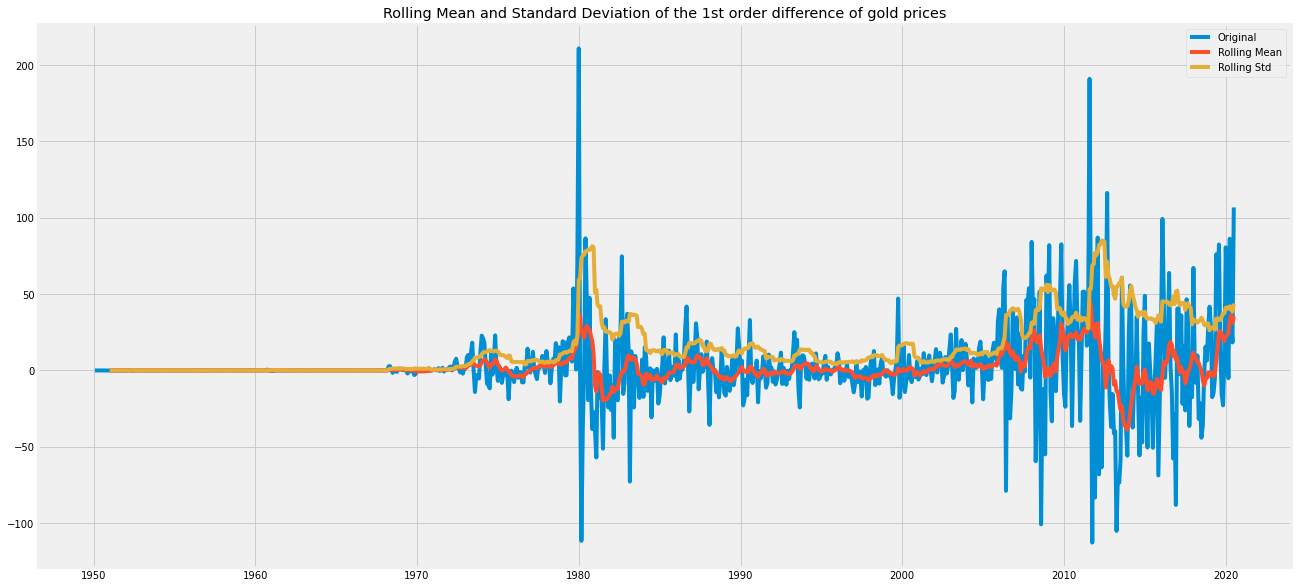

In [ ]:
timeseries = gold.diff()
rolmean = timeseries.rolling(12).mean()
rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
plt.plot(timeseries,label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation of the 1st order difference of gold prices')
plt.show(block=False)

In [ ]:
X= gold['Price'].diff()
print("Results of dickey fuller test")
adft = adfuller(X.iloc[1:],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
  output['critical value (%s)'%key] =  values
print(output)


Results of dickey fuller test
Test Statistics               -6.217087e+00
p-value                        5.333283e-08
No. of lags used               1.000000e+01
Number of observations used    8.350000e+02
critical value (1%)           -3.438206e+00
critical value (5%)           -2.865008e+00
critical value (10%)          -2.568616e+00
dtype: float64


As you can see the p-value is very much less than 0.05 and hence we can safely say that differencing one time will give us a stationary time series.

From the graph we can see that the mean and standard deviation doesn't vary that much and realtively stationary.

The following are partial and full autocorrelation graphs of the differenced dataset.

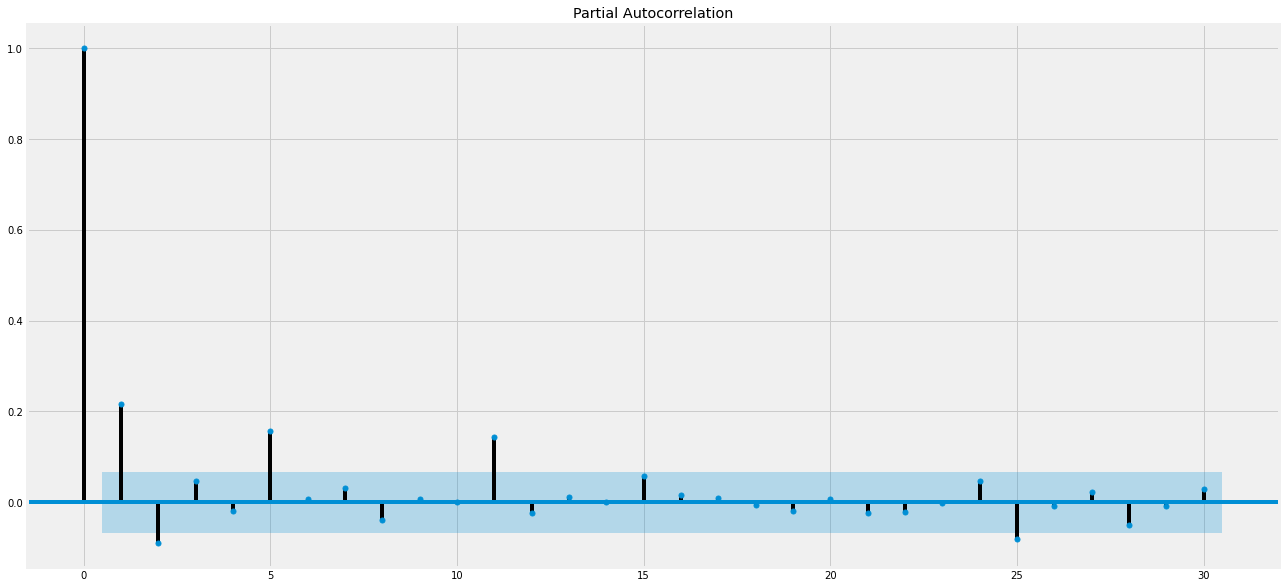

In [ ]:
plot_pacf(X.iloc[1:]);


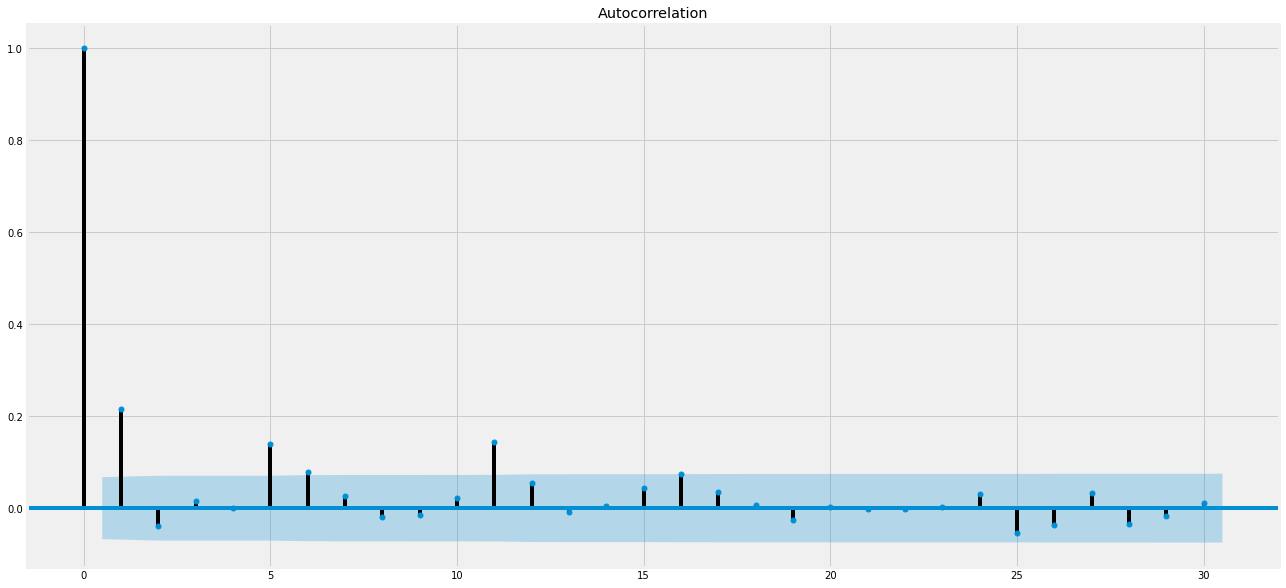

In [ ]:
plot_acf(X.iloc[1:]);

In the follwing section, we model the time series based on different models. 

The AR, MA, ARMA models are modelled somewhat naively only on 100 months and are based on the difference dataset. We assume the order of Auto-Regression and Moving Average as 1 in these 3 models alone just to have a naive look.

The ARIMA model is dealt in more detail and will be used to predict prices.

# AR(Auto Regression) Model

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  846
Model:                     ARMA(1, 0)   Log Likelihood               -3900.090
Method:                       css-mle   S.D. of innovations             24.314
Date:                Sun, 11 Apr 2021   AIC                           7806.180
Time:                        16:36:35   BIC                           7820.401
Sample:                             0   HQIC                          7811.629
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1691      1.072      2.023      0.043       0.067       4.271
ar.L1.y        0.2207      0.034      6.514      0.000       0.154       0.287
                                    Roots           

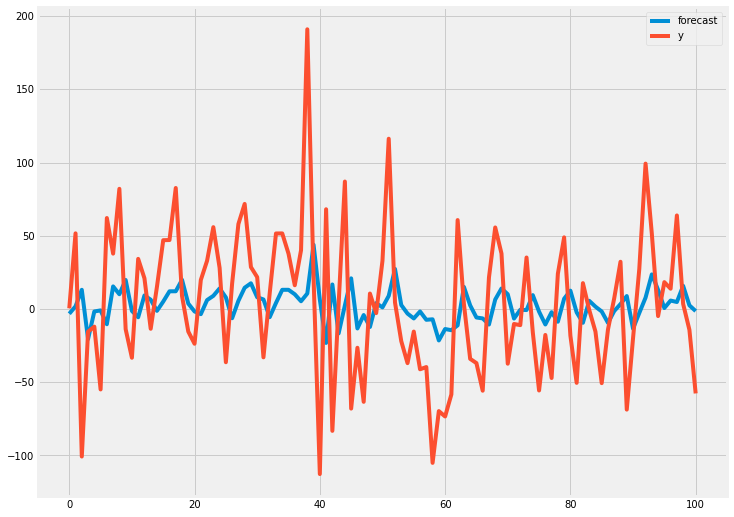

In [ ]:
rcParams['figure.figsize'] = 11, 9

humid = ARMA(gold["Price"].diff().iloc[1:].values, order=(1,0))
res = humid.fit()
print(res.summary())
res.plot_predict(start=700, end=800)
plt.show()

AR model

$\\{y_t} = 0.2207y_{t-1} +  2.1691$

In [ ]:
rmse = math.sqrt(mean_squared_error(gold["Price"].diff().iloc[700:800].values, res.predict(start=700,end=799)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 39.187199265790525.


# MA(Moving Average) Model

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  846
Model:                     ARMA(0, 1)   Log Likelihood               -3896.454
Method:                       css-mle   S.D. of innovations             24.210
Date:                Sun, 11 Apr 2021   AIC                           7798.907
Time:                        16:36:45   BIC                           7813.129
Sample:                             0   HQIC                          7804.356
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1655      1.050      2.063      0.039       0.108       4.223
ma.L1.y        0.2614      0.036      7.199      0.000       0.190       0.333
                                    Roots           

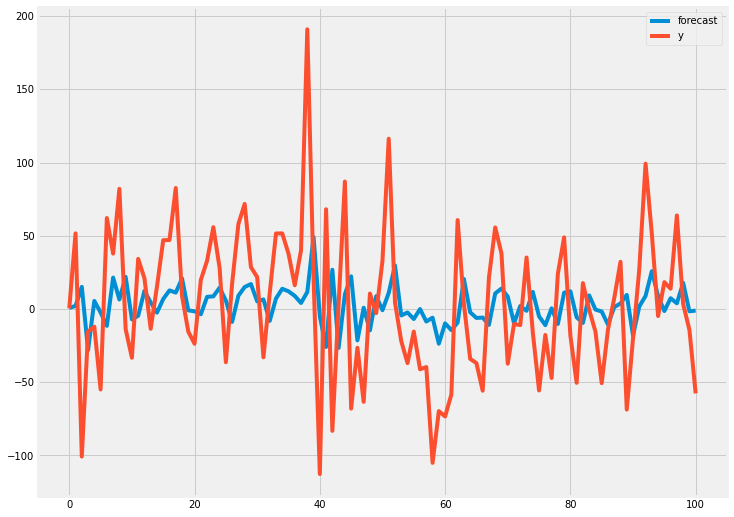

In [ ]:
model = ARMA(gold["Price"].diff().iloc[1:].values, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=700, end=800)
plt.show()

MA model

$\\{y_t} =  0.2614e_{t-1} +  2.1655$

In [ ]:
rmse = math.sqrt(mean_squared_error(gold["Price"].diff().iloc[740:840].values, result.predict(start=740,end=839)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 35.34764684208482.


# ARMA(Auto Regressive and Moving Average) Model

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  846
Model:                     ARMA(1, 1)   Log Likelihood               -3892.049
Method:                       css-mle   S.D. of innovations             24.083
Date:                Mon, 12 Apr 2021   AIC                           7792.098
Time:                        03:28:55   BIC                           7811.060
Sample:                             0   HQIC                          7799.363
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1466      0.947      2.268      0.024       0.291       4.002
ar.L1.y       -0.5511      0.102     -5.390      0.000      -0.751      -0.351
ma.L1.y        0.7734      0.080      9.612      0.0

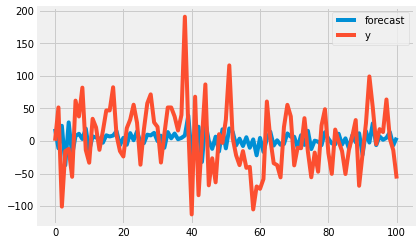

In [ ]:
model = ARMA(gold["Price"].diff().iloc[1:].values, order=(1,1))
result = model.fit()
print(result.summary())
print("μ={}, ϕ={}, θ={}".format(result.params[0],result.params[1],result.params[2]))
result.plot_predict(start=700, end=800)
plt.show()

ARMA model

$\\{y_t} = -0.5511y_{t-1} +  0.7734e_{t-1} +  2.1466$

In [ ]:
rmse = math.sqrt(mean_squared_error(gold["Price"].diff().iloc[1:840].values, result.predict(start=1,end=839)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 20.71555368863668.


# ARIMA Model

No handles with labels found to put in legend.


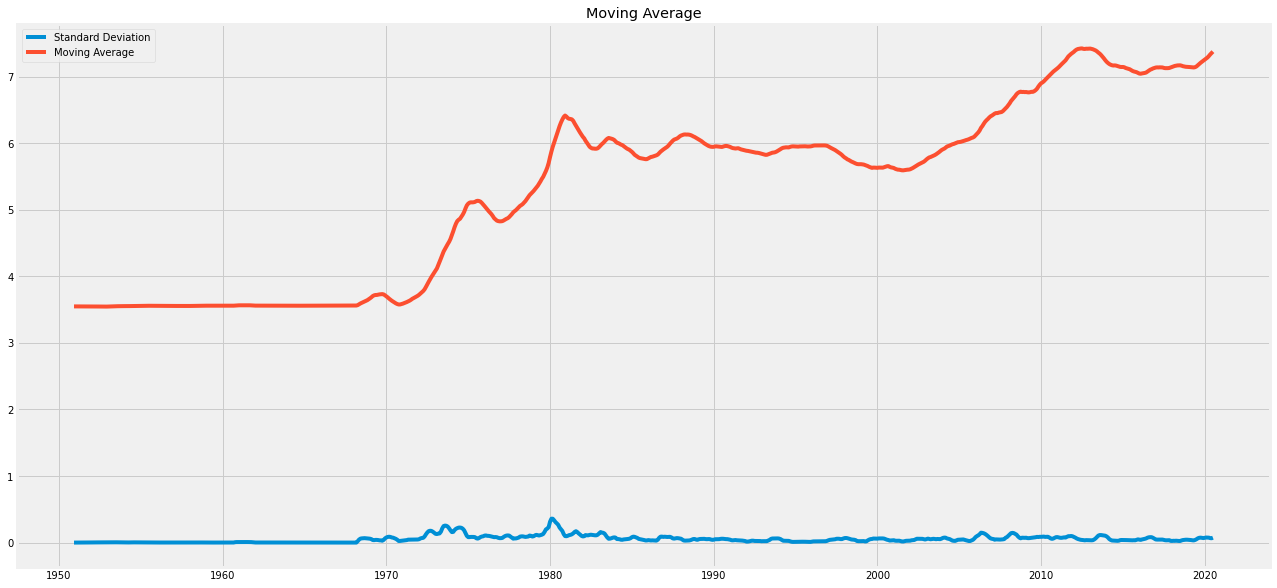

In [ ]:
rcParams['figure.figsize'] = 20, 10
df_log = np.log(gold)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, label = "Standard Deviation")
plt.plot(moving_avg, label = "Moving Average")
plt.legend()


We have taken the log values of our dataset.

We have also graphed the rolling mean and standard deviation, it can be seen that the log dataset is also not stationary.

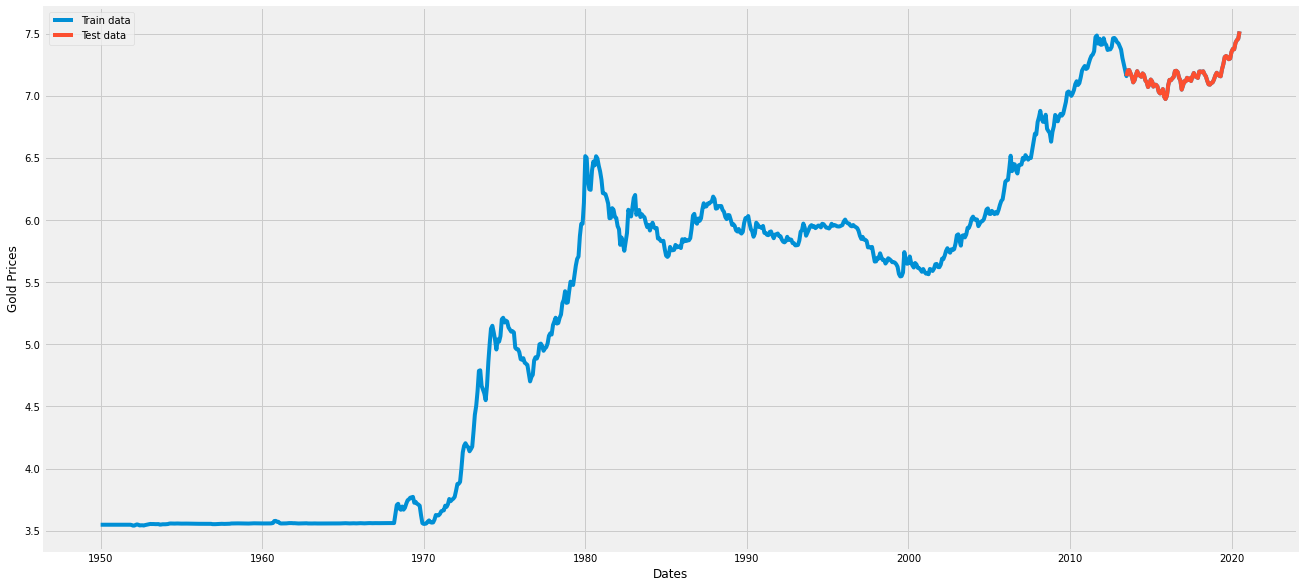

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Gold Prices')
plt.plot(df_log, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

Here we have split the dataset into test dataset and train dataset so that we can use it to determine our prediction's validity.

In the next code segement we use the auto_ARIMA function from a package called pmdarima.

In [ ]:

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2653.686, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2715.800, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2730.618, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2645.723, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2730.696, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2728.543, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2730.048, Time=1.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2730.500, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2725.639, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2729.172, Time=1.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2726.087, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.572 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:       

The auto_ARIMA used automates the process of finding the values of p,d,q in the ARIMA model.

**p** - order of the Autoregressive part

**d** - degree of first differencing involved

**q** - order of the moving average part

Using these three parameters and the data we estimate the coefficients of each part.

We find the value of d by doing the Dickey Fuller test for each order of differencing and finding the least order which doesn't have a p-value of > 0.0.5

We find the value of p and q by finding the Akaike’s Information Criterion (AIC) of the resoective values and finding out which of them has the minimum AIC value and we use them.

This is automated in the auto_ARIMA function, it loops b/w values of 0,1,2 for p and q.

It finds that ARIMA(1,1,1) model is the best model.

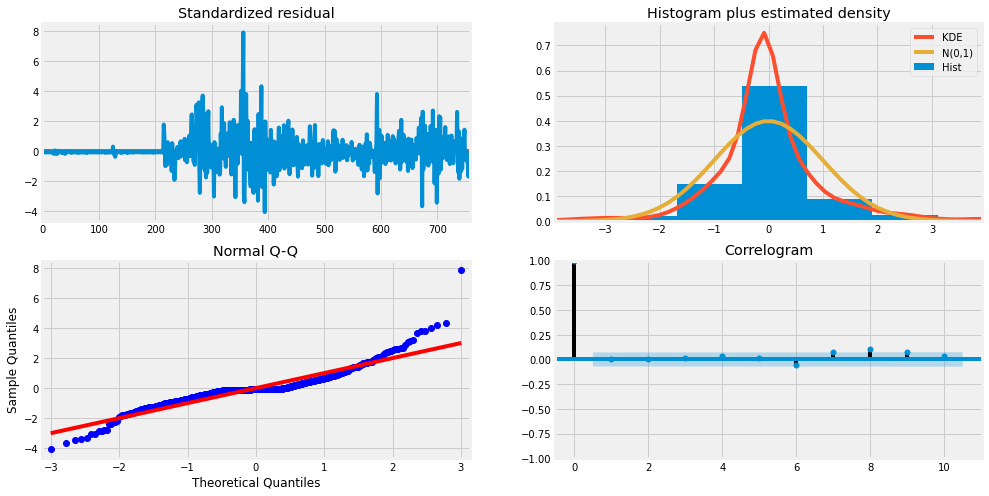

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. 
Next, create an ARIMA model with provided optimal parameters p, d and q.

In [ ]:
model = ARIMA(train_data, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                  758
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1369.348
Method:                       css-mle   S.D. of innovations              0.040
Date:                Mon, 12 Apr 2021   AIC                          -2730.696
Time:                        04:36:54   BIC                          -2712.173
Sample:                    05-01-1950   HQIC                         -2723.562
                         - 06-01-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0048      0.002      2.586      0.010       0.001       0.008
ar.L1.D.Price    -0.1566      0.109     -1.443      0.149      -0.369       0.056
ma.L1.D.Price     0.4885      0.097     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



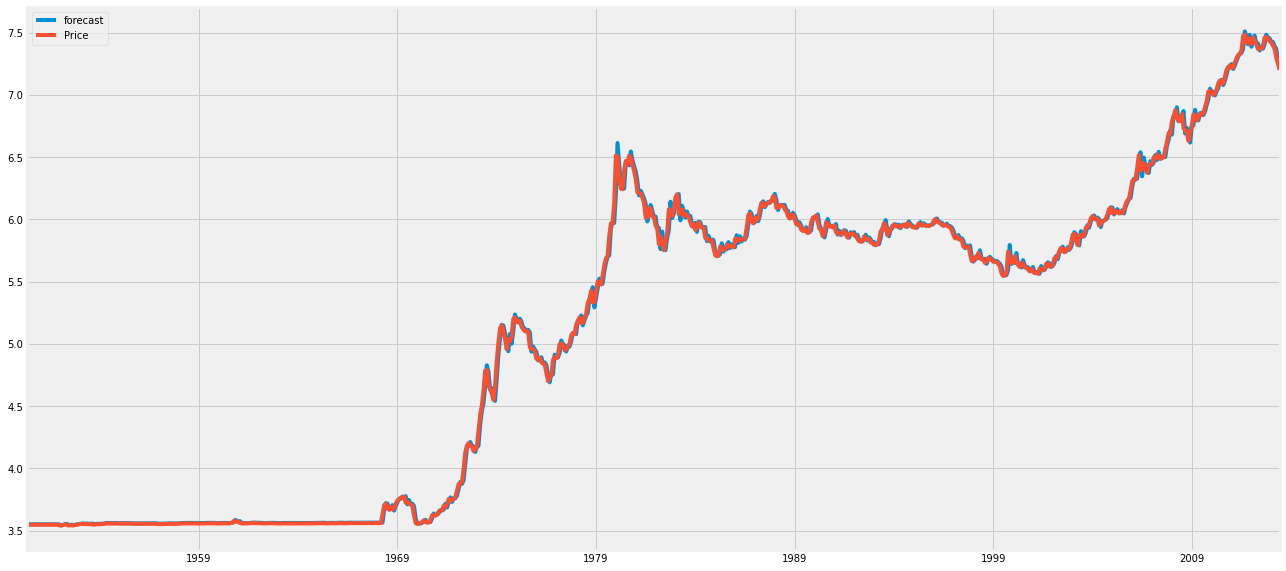

In [ ]:
fitted.plot_predict()
plt.show()

The graph shows the Actual price in red and the Forecasted Price via the ARIMA model in blue.It's safe to say they are very similar.

Thus we use it for prediction of the test data that we have taken.

Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

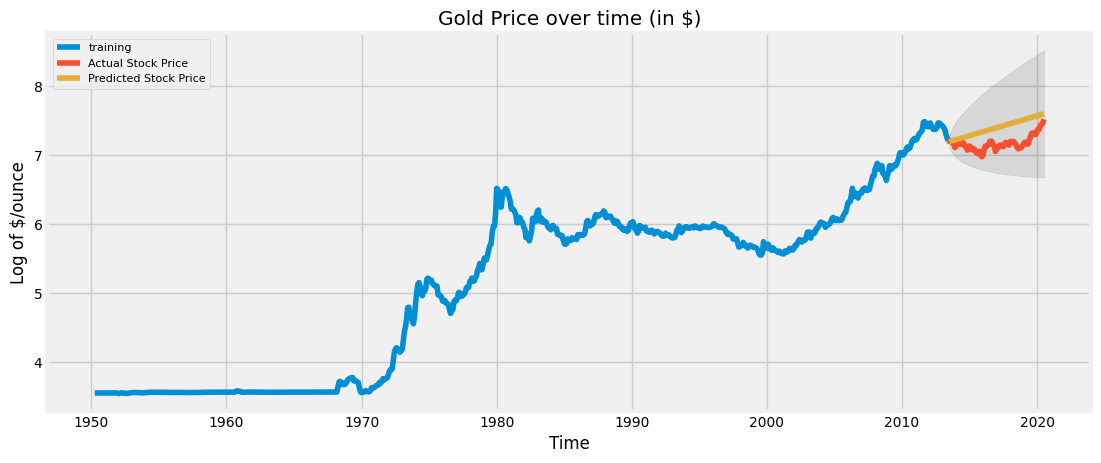

In [ ]:
fc, se, conf = fitted.forecast(85,alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fc_series,label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Gold Price over time (in $)')
plt.xlabel('Time')
plt.ylabel('Log of $/ounce')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can see our model did quite handsomely. Let us also check the commonly used accuracy metrics to judge forecast results:

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.06282530925697012
MAE: 0.22930493237495614
RMSE: 0.2506497741011751


As you can see the RMSE value is 0.25 this is in log.

This kind of ARIMA model can be used for basically any assests in the market not only Gold.